
         Responsible AI & Governance for the PD Model
 
  This notebook continues from `02_PD_models`, where we built a Probability of
  Default (PD) model for retail loans using Logistic Regression and Random Forest.
  Here we focus on **Responsible AI practices and governance**, aligned with an
  AI Risk & Controls role:
 
  - Model validation beyond accuracy: **AUC + calibration**
  - **Global & local explainability** with SHAP and LIME
  - Simple **fairness / bias checks** (by age group)
  - **Monitoring & KRIs** (AUC, data drift via PSI)
  - A small **AI Risk Register**
  - An auto-generated **Model Card** template
 
  This demonstrates how a PD model can be embedded in an AI governance framework.


  For reproducibility, we replay the key steps from `02_PD_models`:
  - Load `Preprocessed_Data.csv`
  - One-hot encode categoricals
  - Train Logistic Regression and Random Forest PD models

      
  Load preprocessed dataset (same as in 02_PD_models)


In [29]:
#!python3 -m pip install shap 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
)
from sklearn.calibration import calibration_curve

import shap

sns.set(style="whitegrid")
RANDOM_STATE = 42
#shap.initjs()


loan_status
0    78.06
1    21.94
Name: proportion, dtype: float64


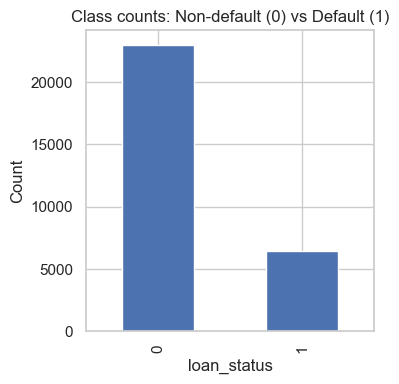

Numeric: ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_status', 'loan_percent_income', 'cb_person_cred_hist_length']
Categorical: ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Models trained.


In [30]:
data = pd.read_csv("../credit_risk_PD/Preprocessed_Data.csv")
data.head()

#Target distribution (loan_status: 0 = non-default, 1 = default)
print(data['loan_status'].value_counts(normalize=True).mul(100).round(2))

plt.figure(figsize=(4, 4))
data['loan_status'].value_counts().plot(kind='bar')
plt.title("Class counts: Non-default (0) vs Default (1)")
plt.xlabel("loan_status")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

      
#Identify numeric & categorical columns
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = data.select_dtypes(include=["object"]).columns.tolist()
print("Numeric:", numeric_cols)
print("Categorical:", categorical_cols)

#One-hot encode categoricals (same pattern as before)
data_num = data.select_dtypes(exclude=['object'])
data_cat = data.select_dtypes(include=['object'])
data_cat_dummies = pd.get_dummies(data_cat, drop_first=True)

data_prep = pd.concat([data_num, data_cat_dummies], axis=1)
data.shape, data_prep.shape

      
#Train / test split
X = data_prep.drop(columns=['loan_status'])
y = data_prep['loan_status']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.4,
    random_state=42,
    stratify=y
)
X_train.shape, X_test.shape

       
#Logistic Regression PD model
log_clf = LogisticRegression(
    solver='lbfgs',
    max_iter=500
)
log_clf.fit(X_train, y_train)

#Random Forest PD model
rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf_clf.fit(X_train, y_train)

print("Models trained.")

=== Logistic Regression ===
AUC: 0.853

Classification report:
              precision    recall  f1-score   support

 Non-default       0.86      0.96      0.91      9199
     Default       0.75      0.45      0.56      2585

    accuracy                           0.85     11784
   macro avg       0.80      0.70      0.73     11784
weighted avg       0.84      0.85      0.83     11784



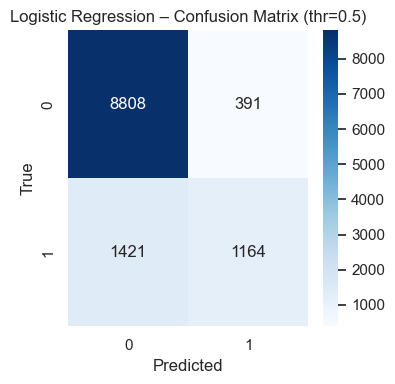

=== Random Forest ===
AUC: 0.930

Classification report:
              precision    recall  f1-score   support

 Non-default       0.93      0.99      0.96      9199
     Default       0.95      0.72      0.82      2585

    accuracy                           0.93     11784
   macro avg       0.94      0.85      0.89     11784
weighted avg       0.93      0.93      0.93     11784



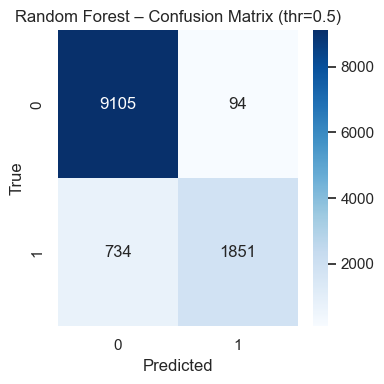

Logistic Regression AUC: 0.853
Random Forest AUC      : 0.930


In [4]:
def evaluate_model(name, model, X_test, y_test, threshold=0.5):
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)

    auc = roc_auc_score(y_test, y_proba)
    print(f"=== {name} ===")
    print(f"AUC: {auc:.3f}\n")
    print("Classification report:")
    print(classification_report(y_test, y_pred, target_names=["Non-default", "Default"]))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} – Confusion Matrix (thr={threshold})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    return auc, y_proba, y_pred

        
auc_log, y_proba_log, y_pred_log = evaluate_model(
    "Logistic Regression", log_clf, X_test, y_test
)

auc_rf, y_proba_rf, y_pred_rf = evaluate_model(
    "Random Forest", rf_clf, X_test, y_test
)

print(f"Logistic Regression AUC: {auc_log:.3f}")
print(f"Random Forest AUC      : {auc_rf:.3f}")



This is the starting point for risk-based discussion: Is this performance adequate for the intended use and risk appetite?

Calibration – are PDs well-calibrated?
   
For PD models used in risk, calibration is crucial: probabilities should match observed default frequencies. We plot calibration curves for both models.

        


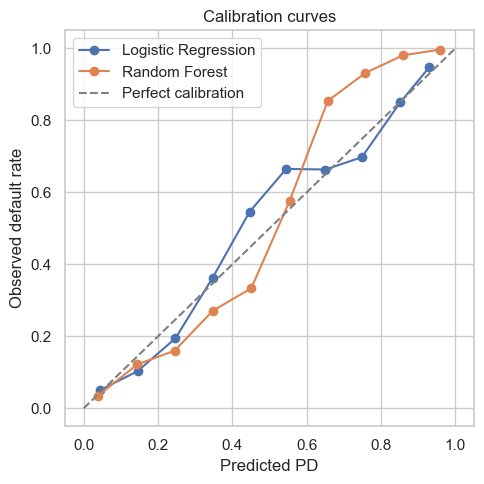

In [31]:
def plot_calibration_curve(model, X_test, y_test, name, n_bins=10):
    y_proba = model.predict_proba(X_test)[:, 1]
    prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=n_bins)

    plt.plot(prob_pred, prob_true, marker="o", label=name)
    


plt.figure(figsize=(5, 5))
        
plot_calibration_curve(log_clf, X_test, y_test, "Logistic Regression")
plot_calibration_curve(rf_clf, X_test, y_test, "Random Forest")
plt.plot([0, 1], [0, 1], "--", color="gray", label="Perfect calibration")
plt.xlabel("Predicted PD")
plt.ylabel("Observed default rate")
plt.title(f"Calibration curves")
plt.legend()
plt.tight_layout()
plt.show()


Let us now see how explainable these models are. Logistic Regression is naturally interpretable via its coefficients. We can show which features increase / decrease PD, which is useful to ensure no protected attributes are introducing biases.

,feature,coefficient
17,loan_grade_D,0.991609
18,loan_grade_E,0.674504
9,person_home_ownership_RENT,0.665314
11,loan_intent_HOMEIMPROVEMENT,0.515213
5,loan_percent_income,0.433520
4,loan_int_rate,0.191431
19,loan_grade_F,0.135873
20,loan_grade_G,0.121109
6,cb_person_cred_hist_length,0.088176
21,cb_person_default_on_file_Y,0.073581


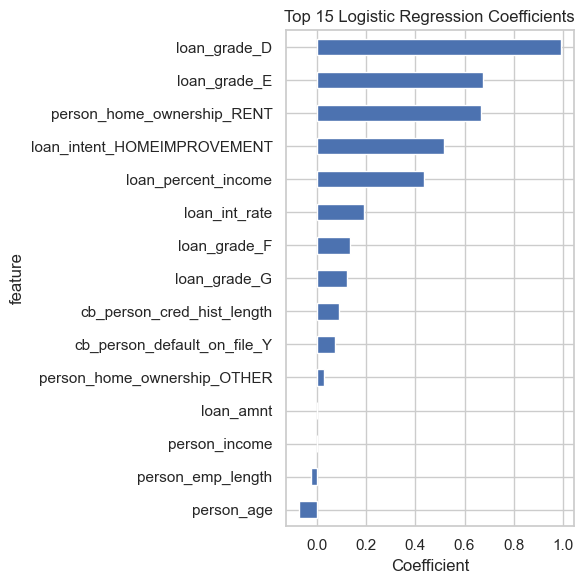

In [32]:
#Logistic Regression coefficients
coef_df = pd.DataFrame({
    "feature": X_train.columns,
    "coefficient": log_clf.coef_[0]
}).sort_values("coefficient", ascending=False)

display(coef_df.head(15))

plt.figure(figsize=(6, 6))
coef_df.set_index("feature")["coefficient"].head(15).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top 15 Logistic Regression Coefficients")
plt.xlabel("Coefficient")
plt.tight_layout()
plt.show()



For the more complex Random Forest, we use **SHAP TreeExplainer** to understand:
    - overall feature importance (which drivers matter most),
    - how features influence PD (direction & magnitude).

In [37]:
print("Creating SHAP TreeExplainer...")

#Create a TreeExplainer
explainer = shap.TreeExplainer(rf_clf)

#Step 2: Select a specific prediction to explain (for individual explanation)

example_idx = 0    #Select first test sample
selected_instance = X_test_sample.iloc[[example_idx]]
print(f"Selected instance features:")
for col in selected_instance.columns:
    print(f"{col}: {selected_instance[col].values[0]}")
#Predict for this instance    
prediction = rf_clf.predict_proba(selected_instance)[0]
predicted_class = rf_clf.predict(selected_instance)[0]

print(f"\n\nModel prediction for selected instance: Class {predicted_class}")
print(f"Probability distribution: {prediction}")



Creating SHAP TreeExplainer...
Selected instance features:
person_age: 38
person_income: 60000
person_emp_length: 3.0
loan_amnt: 5000
loan_int_rate: 14.79
loan_percent_income: 0.08
cb_person_cred_hist_length: 17
person_home_ownership_OTHER: False
person_home_ownership_OWN: False
person_home_ownership_RENT: True
loan_intent_EDUCATION: True
loan_intent_HOMEIMPROVEMENT: False
loan_intent_MEDICAL: False
loan_intent_PERSONAL: False
loan_intent_VENTURE: False
loan_grade_B: False
loan_grade_C: True
loan_grade_D: False
loan_grade_E: False
loan_grade_F: False
loan_grade_G: False
cb_person_default_on_file_Y: True


Model prediction for selected instance: Class 0
Probability distribution: [0.805 0.195]


In [38]:
#Debug the structure of the SHAP values
print("Calculating SHAP values...")
shap_values = explainer.shap_values(selected_instance)
print("SHAP values type:", type(shap_values))
print("SHAP values shape:", shap_values.shape)


Calculating SHAP values...
SHAP values type: <class 'numpy.ndarray'>
SHAP values shape: (1, 22, 2)


In [39]:
#Step 3: Create a visualization based on the actual shape (1, 22, 2)
print("Creating visualization of feature impacts...")
#Extract values for the positive class (index 1) for all features
#   From the debug output: shape is (1, 22, 2) where:
#   - 1 is the number of instances
#   - 22 is the number of features
#   - 2 is the number of classes (0: <=50K, 1: >50K)

positive_class_values = shap_values[0, :, 1]    #Shape should be (22,)
print("Positive class values shape:", positive_class_values.shape)
print("First few positive class values:", positive_class_values[:5])
feature_names = selected_instance.columns

Creating visualization of feature impacts...
Positive class values shape: (22,)
First few positive class values: [ 0.02067261 -0.03085244 -0.02702616 -0.00460408  0.10999529]


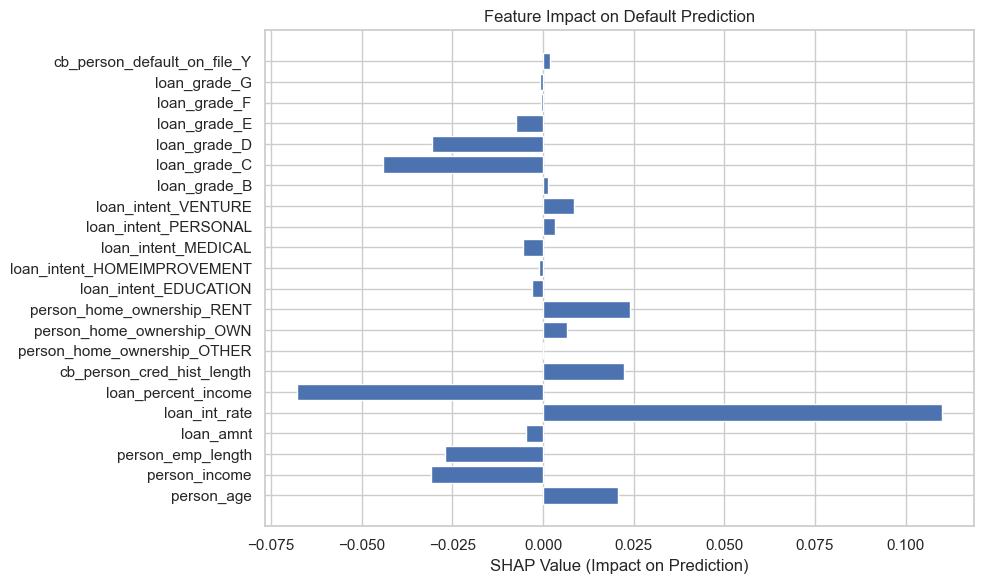

In [42]:
# Create a simple bar chart showing feature impacts for the positive class
plt.figure(figsize=(10, 6))
plt.title("Feature Impact on Default Prediction")
y_pos = np.arange(len(feature_names))
plt.barh(y_pos, positive_class_values)
plt.yticks(y_pos, feature_names)
plt.xlabel("SHAP Value (Impact on Prediction)")
plt.tight_layout()
plt.show()
#plt.savefig("individual_explanation.png")
#plt.close()

In [43]:

#Compute SHAP values  
sample_idx = np.random.choice(X_test.shape[0], size=min(500, X_test.shape[0]), replace=False) #smaller sample for speed
X_test_sample = X_test.iloc[sample_idx]
shap_values = explainer.shap_values(X_test_sample)

sv.shape: (500, 22, 2)
X_test_sample.shape: (500, 22)


Creating feature importance bar chart...


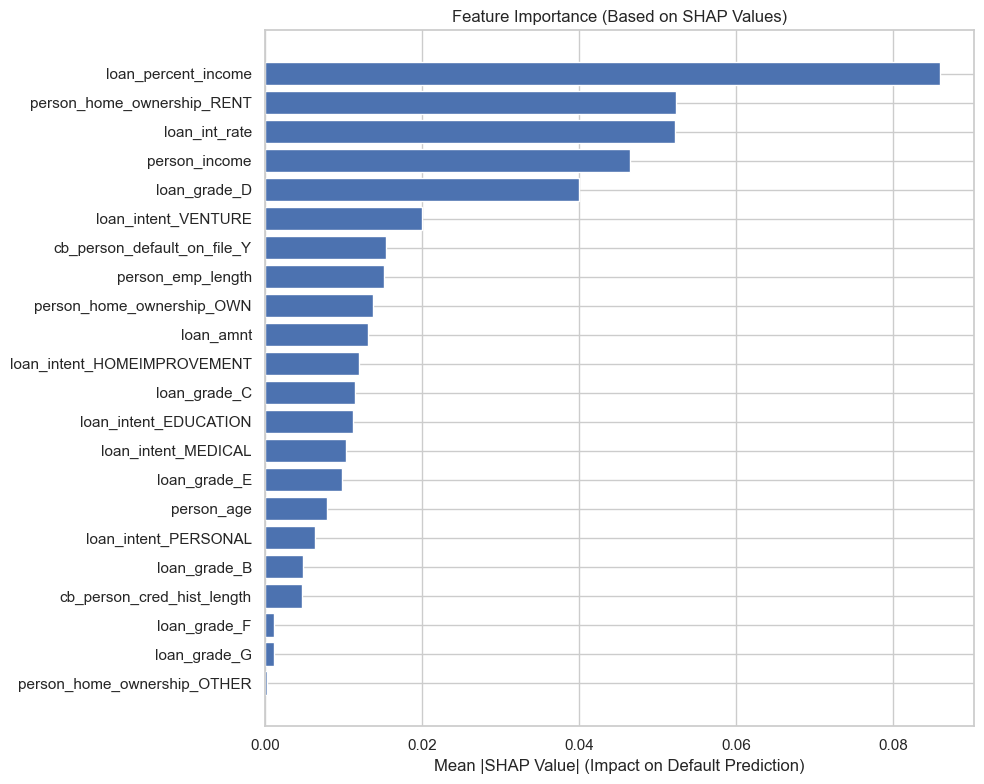

In [46]:

print("Creating feature importance bar chart...")
plt.figure(figsize=(10, 8))
plt.title("Feature Importance (Based on SHAP Values)")

#Calculate feature importance as mean absolute SHAP value for positive class
feature_importance = np.abs(shap_values[:, :,1]).mean(axis=0)   # Mean across samples
indices = np.argsort(feature_importance)   # Get indices for sorting
#Plot sorted feature importance
feature_names = X_test_sample.columns
plt.barh(range(len(feature_names)), feature_importance[indices])
plt.yticks(range(len(feature_names)), [feature_names[i] for i in indices])
plt.xlabel("Mean |SHAP Value| (Impact on Default Prediction)")
plt.tight_layout()
plt.show()
#plt.savefig("shap_feature_importance.png")

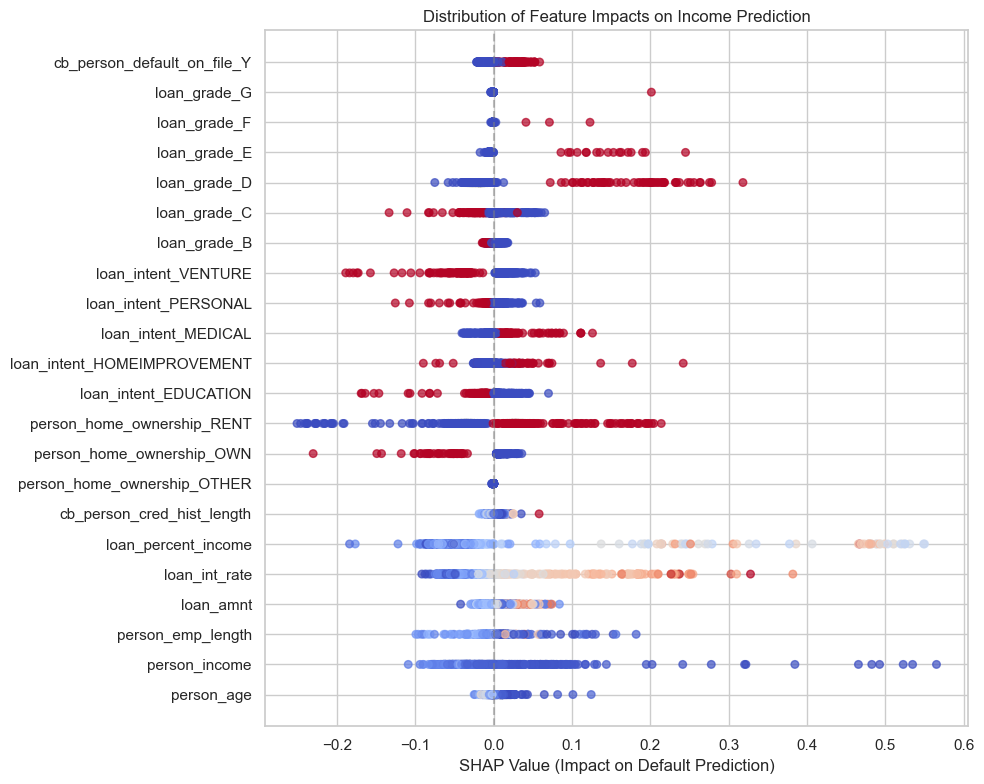

In [50]:
plt.figure(figsize=(10, 8))
plt.title("Distribution of Feature Impacts on Income Prediction")
#Create a simplified version of the SHAP summary plot 
#For each feature, scatter plot the SHAP values
for i, feature in enumerate(feature_names):
   #Get SHAP values for this feature across all samples for positive class
   feature_shap_values = shap_values[:, i, 1]
   #Get feature values for coloring
   feature_values = X_test_sample[feature].values
   #Normalize feature values to 0-1 range for coloring
   if feature_values.dtype == bool:
     feature_values = feature_values.astype(int)

   min_v = feature_values.min()
   max_v = feature_values.max()

   if max_v > min_v:
        norm_values = (feature_values - min_v) / (max_v - min_v)
   else:
        norm_values = np.zeros_like(feature_values, dtype=float)

   #Plot points with color based on feature value
   plt.scatter(feature_shap_values, 
               np.ones(len(feature_shap_values)) * i,  # y-position based on feature index
               c=norm_values,
               cmap='coolwarm',  # Red for high values, blue for low
               alpha=0.7,
               s=30)
plt.yticks(range(len(feature_names)), feature_names)
plt.xlabel("SHAP Value (Impact on Default Prediction)")
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)  # Zero line
plt.tight_layout()
plt.show()
#plt.savefig("shap_distribution_plot.png")
#plt.close()

SHAP helps explain Random Forest behaviour in language suitable for non-technical stakeholders: which variables primarily drive PD and how shifts in those variables change risk.

## Fairness / bias check: age groups
 As a simple Responsible AI step, we check whether model behaviour differs across
 age groups (used here as a proxy sensitive attribute).

 We compute per-age-group:
 - default rate in data,
 - predicted high-risk rate (PD > 0.5),
 - false positive and false negative rates.

/var/folders/yd/9m_x6xcd71jc27zn8nj9jjxw0000gn/T/ipykernel_81323/3402718170.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fairness_summary = fairness_df.groupby("age_group").apply(group_metrics)
/var/folders/yd/9m_x6xcd71jc27zn8nj9jjxw0000gn/T/ipykernel_81323/3402718170.py:36: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fairness_summary = fairness_df.groupby("age_group").apply(group_metrics)


,default_rate,high_risk_rate,FPR,FNR
age_group,,,,
<30,0.226934,0.140224,0.044774,0.534617
30–60,0.199088,0.109422,0.036053,0.595420
>60,0.310345,0.275862,0.150000,0.444444


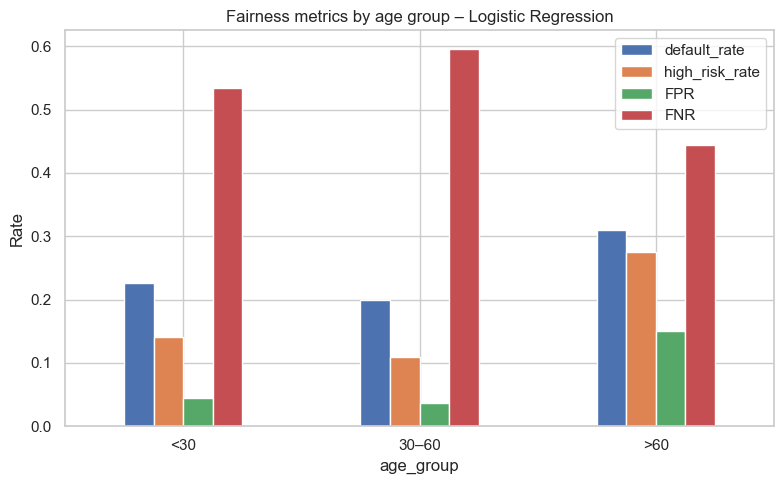

In [54]:
AGE_COL = "person_age"    
THRESHOLD = 0.5

age_test = data.loc[X_test.index, AGE_COL]
age_bins = [0, 30, 60, np.inf]
age_labels = ["<30", "30–60", ">60"]
age_group = pd.cut(age_test, bins=age_bins, labels=age_labels, right=False)

y_true = y_test
y_proba_lr = y_proba_log
y_pred_lr = (y_proba_lr >= THRESHOLD).astype(int)

fairness_df = pd.DataFrame({
    "age_group": age_group,
    "y_true": y_true,
    "y_pred": y_pred_lr,
    "y_proba": y_proba_lr
}).dropna(subset=["age_group"])

def group_metrics(g):
    default_rate = g["y_true"].mean()
    high_risk_rate = g["y_pred"].mean()
    cm = confusion_matrix(g["y_true"], g["y_pred"], labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()

    fpr = fp / (fp + tn) if (fp + tn) > 0 else np.nan
    fnr = fn / (fn + tp) if (fn + tp) > 0 else np.nan

    return pd.Series({
        "default_rate": default_rate,
        "high_risk_rate": high_risk_rate,
        "FPR": fpr,
        "FNR": fnr
    })

fairness_summary = fairness_df.groupby("age_group").apply(group_metrics)
display(fairness_summary)

fairness_summary.plot(kind="bar", figsize=(8, 5))
plt.title("Fairness metrics by age group – Logistic Regression")
plt.ylabel("Rate")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()



Finally, we create a **Model Card** template summarising key aspects of governance.

In [55]:
model_card_md = f"""
   Model Card – Retail Loan PD Model

     1. Model Details

- **Model type:** Binary classification (Probability of Default)
- **Algorithms:**
  - Logistic Regression (baseline, interpretable)
  - Random Forest (non-linear comparator for higher AUC)
- **Primary metrics (hold-out test set):**
  - Logistic Regression AUC: {auc_log:.3f}
  - Random Forest AUC: {auc_rf:.3f}

     2. Intended Use and Scope

- **Intended use:** Estimating PD for retail loan applications to support credit risk
  decisions and portfolio-level risk management.
- **Intended users:** Credit risk teams, model risk management, AI governance teams.
- **Out-of-scope:** Fully automated approvals/declines without human oversight; use on
  populations materially different from the training data.

     3. Data

- **Source:** Tabular loan-level dataset with demographic and loan characteristics.
- **Key features:** Age, income, loan amount, loan grade/intent, interest rate,
  home ownership, credit history length, prior default flag.
- **Preprocessing:** Categorical variables one-hot encoded; numeric variables used
  at native scale (no standardisation in this version).
- **Data quality checks:** Basic missing-value and distribution checks performed
  prior to modelling. Imputation applied for missing numeric values using median. 

     4. Evaluation and Validation

- **Metrics:** AUC, confusion matrix, precision/recall, and PD calibration curves.
- **Calibration:** Calibration curves were examined for both models; deviations from
  the diagonal would trigger recalibration or model redesign.
- **Threshold analysis:** Different PD cut-offs were explored to balance default
  recall vs overall accuracy.

     5. Explainability

- **Logistic Regression coefficients:** Used to interpret the direction and strength
  of each feature's effect on PD.
- **SHAP (TreeExplainer) for Random Forest:**
  - Case-level explanation generated to identify which features increased or
    decreased PD for a specific loan applicant.
  - Global summary plots used to identify the most influential features.
  - Dependence plots used to show how changes in key features affect predicted PD.


     6. Fairness and Ethical Considerations

- **Proxy sensitive attribute analysed:** Age, grouped into <30, 30–60, >60.
- **Metrics per group:** Default rate, predicted high-risk rate (PD > {0.5:.2f}),
  false positive rate (FPR), and false negative rate (FNR).
- **Observations:** Any persistent gaps between age groups are treated as potential
  disparate impact and require further investigation (e.g. threshold tuning, feature
  review, or model simplification).
- **Limitations:** Only age was analysed here; a full assessment would cover more
  protected characteristics and intersectional groups, subject to data availability
  and legal constraints.


     7. Limitations and Next Steps

- **Scope limitations:** Single dataset, limited fairness dimensions, no stress
  testing of extreme scenarios.
- **Planned enhancements:**
  - Broader fairness analysis across additional attributes.
  - No drift monitoring and automation of the KRI dashboard.
  - Missing Governance aspects such as versioning, access controls, and audit trails.
  - Alignment with evolving AI regulations and internal AI governance standards.
"""

print(model_card_md)



   Model Card – Retail Loan PD Model

     1. Model Details

- **Model type:** Binary classification (Probability of Default)
- **Algorithms:**
  - Logistic Regression (baseline, interpretable)
  - Random Forest (non-linear comparator for higher AUC)
- **Primary metrics (hold-out test set):**
  - Logistic Regression AUC: 0.853
  - Random Forest AUC: 0.930

     2. Intended Use and Scope

- **Intended use:** Estimating PD for retail loan applications to support credit risk
  decisions and portfolio-level risk management.
- **Intended users:** Credit risk teams, model risk management, AI governance teams.
- **Out-of-scope:** Fully automated approvals/declines without human oversight; use on
  populations materially different from the training data.

     3. Data

- **Source:** Tabular loan-level dataset with demographic and loan characteristics.
- **Key features:** Age, income, loan amount, loan grade/intent, interest rate,
  home ownership, credit history length, prior default flag.
- 